## Анализ данных о приложениях

Имеем 2 файла с информацией о приложениях: 
1. **googleplaystore.csv** (информация о приложениях) содержит поля:

* App – название приложения
* Category – категория приложения
* Rating – средний рейтинг приложения
* Reviews – количество отзывов пользователей на приложение
* Size – размер приложения
* Installs – количество загрузок/установок приложения
* Type – тип приложения (платное/бесплатное)
* Price – цена приложения
* Content Rating – возрастной ценз
* Genres – жанры приложения (может содержать несколько значений, разделенных точкой с запятой)
* Last Updated – дата последнего обновления приложения
* Current Ver – текущая версия приложения
* Android Ver – требуемая версия Android
2. **googleplaystore_user_reviews.csv** (информация об отзывах) содержит поля:
* App – название приложения
* Translated Review – текст отзыва на английском языке
* Sentiment – эмоциональный окрас отзыва
* Sentiment_Polarity – скор полярности отзыва
* Sentiment_Subjectivity – скор субъективности отзыва


In [517]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import mannwhitneyu
plt.rcParams['figure.figsize'] = (8, 5)

In [518]:
# Прочитаем данные
apps_df = pd.read_csv(r'H:\Ofiles\Data_analysis\Лента\Тестовое задание\google-play-store-apps\googleplaystore.csv')
reviews_df   = pd.read_csv(r'H:\Ofiles\Data_analysis\Лента\Тестовое задание\google-play-store-apps\googleplaystore_user_reviews.csv')

### 1. Очистка данных и преобразования для последующего анализа

Проведем предобработку данных в каждом из датафреймов. Для этого выполним следующие шаги:

1. посмотрим на head() таблицы
2. просмотрим общую информацию о датафрейме при помощи метода info() - получим информацию о типах данных и пропусках
3. названия столбцов приведем к формату, удобному для обращения: нижний регистр, нижнее подчеркивание вместо пробела
4. категориальные переменные также приведем к нижнему регистру, так как это возможный источник скрытых дубликатов
3. обработаем пропуски, в зависимости от их характера
4. проверим на наличие дубликатов и при необходимости избавимся от них
5. поменяем тип данных для столбцов, содержащих численные данные и информацию о дате

In [519]:
# Взглянем на данные в датафрейме
apps_df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [520]:
# Общая информация
apps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [521]:
# Заменим пробелы на нижнее подчеркивание в заголовках столбцов и приведем их к нижнему регистру для удобства обращения
apps_df.rename(columns=lambda x: x.replace(' ','_').lower(), inplace=True)
reviews_df.rename(columns=lambda x: x.replace(' ','_').lower(), inplace=True)

In [522]:
# Приведем к нижнему регистру название приложений (разный регистр - потенциальный источник скрытых дубликатов),
# а также другие текстовые столбцы
apps_df.app = apps_df.app.apply(lambda x: x.lower())
apps_df.category = apps_df.category.apply(lambda x: x.lower())

In [523]:
# При попытке преобразовать тип данных видим, что нам мешают некоторые значения. 
# Похоже, что в одной строке данные "съехали" на 1 столбец - значения не соответствуют названиям столбцов
apps_df.query('price == "Everyone"')

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,life made wi-fi touchscreen photo frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [524]:
# Сдвинем значения этой строки на 1 столбец, начиная с category
apps_df.loc[10472,'category':'android_ver'] =  apps_df.loc[10472,'category':'android_ver'].shift(periods=1, axis=0)

In [525]:
# Категория данного приложения отсутствует - очевидно, это photography. Вставим пропущенное значение.
apps_df.loc[10472,'category'] = 'photography'

In [526]:
# Удалим знак $ в столбце price
apps_df['price']   = apps_df['price'].apply(lambda x: x.replace('$',''))

In [527]:
# Удалим лишние символы из столбца installs, чтобы работать с ним, как с числовым столбцом
apps_df.installs = apps_df.installs.apply(lambda x: x.replace('+','').replace(',',''))

In [528]:
# Поменяем тип данных в колонках c датой и числовыми данными
apps_df['reviews'] = apps_df['reviews'].astype('int')
apps_df['price'] = apps_df['price'].astype('float')
apps_df['last_updated'] = pd.to_datetime(apps_df['last_updated'])
apps_df['rating'] = apps_df['rating'].astype('float')
apps_df.installs = apps_df.installs.astype('int')

#### Пропущенные значения
Почти у 1,5 тысячи приложений отсутствует информация о рейтинге. Очевидно, некоторые приложения в действительности могут не иметь отзывов. Удалять эти строки из датафрейма было бы неверно, так как они могут быть полезны для анализа других признаков, помимо рейтинга.

In [529]:
# Проверим на наличие пропущенных значений
apps_df.isna().sum()

app                  0
category             0
rating            1474
reviews              0
size                 0
installs             0
type                 1
price                0
content_rating       0
genres               1
last_updated         0
current_ver          8
android_ver          2
dtype: int64

In [530]:
# Проверим данные на наличие дубликатов
apps_df.duplicated().sum()

483

In [531]:
# Удалим дубликаты
apps_df.drop_duplicates(inplace = True)

In [532]:
# Посмотрим на размеры получившегося датафрейма
apps_df.shape

(10358, 13)

In [533]:
# проверим, что названия приложений в столбце app уникальны. Их число должно быть равно числу строк.
apps_df.app.nunique()

9639

In [534]:
# Некоторые приложения по-прежнему дублируются в датафрейме. 
#Удалим дубликаты по столбцу app - мы хотим видеть каждое приложение только 1 раз для целей анализа
apps_df.drop_duplicates(subset = ['app'], inplace = True)

In [535]:
# Проверим, что число строк соответстует числу уникальных значений
apps_df.shape

(9639, 13)

Предобработаем датафрейм с отзывами, выполним шаги:
1. посмотрим на head() таблицы
2. просмотрим общую информацию о датафрейме при помощи метода info() - получим информацию отипах данных и пропусках
3. названия столбцов приведем к формату, удобному для обращения: нижний регистр, нижнее подчеркивание вместо пробела
4. категориальные переменные также приведем к нижнему регистру, так как это возможный источник скрытых дубликатов
3. обработаем пропуски
4. проверим на наличие дубликатов и при необходимости избавимся от них

In [536]:
# Взглянем на датафрейм с отзывами
reviews_df.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [537]:
# Посмотрим общую информацию о нём
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app                     64295 non-null  object 
 1   translated_review       37427 non-null  object 
 2   sentiment               37432 non-null  object 
 3   sentiment_polarity      37432 non-null  float64
 4   sentiment_subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


#### Пропущенные значения
Видим, что в таблице с отзывами много пропущенных значений, притом большинство строк пустые целиком (кроме столбца App), то есть не несут никакой полезной информации. Удалим их.

In [538]:
# Избавимся от строк с пропущенными значениями
reviews_df.dropna(inplace = True)

In [539]:
# Приведем к нижнему регистру текстовые столбцы
reviews_df.app = reviews_df.app.apply(lambda x: x.lower())
reviews_df.translated_review = reviews_df.translated_review.apply(lambda x: x.lower())
reviews_df.sentiment = reviews_df.sentiment.apply(lambda x: x.lower())

In [540]:
# Проверим на наличие дубликатов - их довольно много
reviews_df.duplicated().sum()

7788

#### Дубликаты
У отзывов нет поля id, что осложняет задачу с пониманием дублирования данных. Однако мы можем предположить, что отзывы с идентичным текстом и оценками представляют собой дубликаты. Часть отзывов могут быть заказными. Особенно похожи на них отзывы "good", "bad" и со стандартными оценками. Мы исключим дубликаты из рассмотрения.

In [541]:
reviews_df[reviews_df.translated_review == 'good'].head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
40,10 best foods for you,good,positive,0.7,0.6
78,10 best foods for you,good,positive,0.7,0.6
79,10 best foods for you,good,positive,0.7,0.6
140,10 best foods for you,good,positive,0.7,0.6
178,10 best foods for you,good,positive,0.7,0.6


In [542]:
reviews_df.drop_duplicates(inplace = True)

### 2. Самая популярная категория приложений. Распределение приложений по категориям

In [544]:
# Определим категорию с наибольшим количеством приложений
apps_category_count = apps_df.groupby('category', as_index = False) \
                             .agg({'app':'count'}) \
                             .sort_values('app',ascending = False)
apps_category_count.head(1)

,category,app
11,family,1827


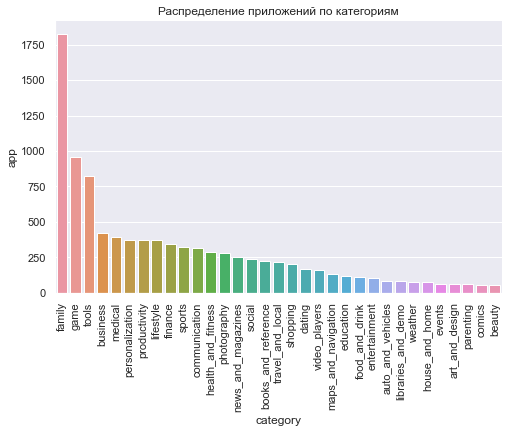

In [545]:
# Построим график распределения приложений по категориям
sns.barplot(x='category', y='app', data = apps_category_count)
sns.set()
plt.xticks(rotation=90)
plt.title('Распределение приложений по категориям')
sns.despine()

Самой популярной категорией приложений является категория family - различные образовательные и развлекательные приложения для семейного круга лиц. Далее, также с большим отрывом, следуют категории game и tools, которые также составляют значиельную долю рынка приложений.

### 3. Приложения с наибольшим количеством установок

In [546]:
# Посмотрим, каково максимальное количество установок для приложений и сколько приложений входит в эту группу
apps_df.groupby('installs', as_index = False).agg({'app':'count'}).sort_values('installs', ascending = False).head(1)

,installs,app
19,1000000000,20


In [547]:
# Выведем приложения с наибольшим количеством установок - более 1 млрд.
apps_df.query('installs == 1000000000').app

152                            google play books
335     messenger – text and video chat for free
336                           whatsapp messenger
338                 google chrome: fast & secure
340                                        gmail
341                                     hangouts
391                skype - free im & video calls
865                            google play games
1654                              subway surfers
2544                                    facebook
2545                                   instagram
2554                                     google+
2808                               google photos
3117                   maps - navigate & explore
3127                          google street view
3234                                      google
3454                                google drive
3665                                     youtube
3687                     google play movies & tv
3736                                 google news
Name: app, dtype: ob

Приложения с наибольшим количеством скачиваний (более 1 млрд) в значительной степени представлены приложениями IT-корпорации Google, затем Facebook, что выглядит вполне закономерным.

### 4. Рейтинг приложений в самых популярных категориях - график распределения

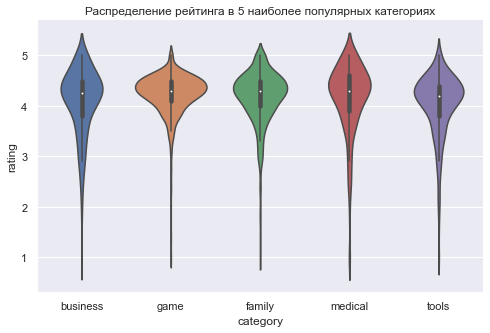

In [548]:
# построим график распределения в 5 самых популярных категориях приложений
sns.violinplot(x = 'category', y = 'rating', \
               data = apps_df.query('category in ["family", "game", "tools", "business", "medical"]'))
plt.title('Распределение рейтинга в 5 наиболее популярных категориях')
sns.despine()

Видим, что медианное значение рейтинга 5 самых популярных приложений распределено вокруг чуть выше 4 (4.1 - 4.2). При этом интересны следующие наблюдения:
1. У игр рейтинг наиболее сконцентрирован вокруг медианы и имеет самый короткий "хвост". Пользователи игр выглядят наиболее лояльными пользователями.
2. У приложений из категорий "business" и "medical" распределения наиболее "растянутые" и имеют самые длинные "хвосты". По-видимому, у пользователей этих приложений ожидания довольно часто не совпадают с действительностью. Характер взаимодействия с такими приложениями гораздо менее предсказуем и прозрачен, чем с играми.


### 5. Проверка гипотезы о том, что средний рейтинг платных приложений отличается от бесплатных

In [549]:
# Посмотрим на средний рейтинг и медиану в каждом из типов приложений
apps_df.groupby('type').agg({'rating':['mean','median']})

rating       
          mean median
type                 
Free  4.166631    4.3
Paid  4.260631    4.4

Выдвинем гипотезу о том, что рейтинг платных приложений статичтически значимо выше, чем рейтинг бесплатных. 

Перед применением критерия оценки разности средних (t-test) оценим нормальность распределения и гомогенность дисперсий в 2 выборках. Не забудем исключить отсутствующие значения рейтинга.

In [550]:
# Отфильтруем необходимые значения по платным и бесплатным приложениям
free_apps = apps_df[apps_df.rating.notna()].query('type == "Free"').rating
paid_apps = apps_df[apps_df.rating.notna()].query('type == "Paid"').rating

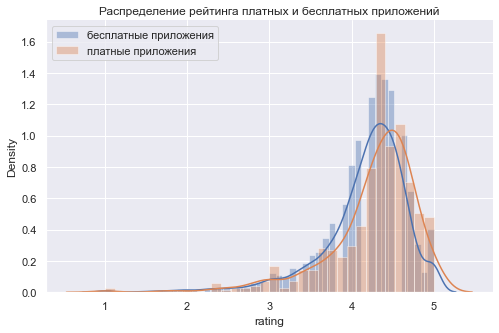

In [551]:
# Взглянем на распределение рейтинга в каждом из 2 типов приложений
sns.distplot(free_apps, label = 'бесплатные приложения')
sns.distplot(paid_apps, label = 'платные приложения')
plt.legend()
plt.title('Распределение рейтинга платных и бесплатных приложений')
sns.despine()

In [552]:
# Проверим на гомогенность дисперсий наши выборки
stats.levene(free_apps, paid_apps)

LeveneResult(statistic=0.19315900599874208, pvalue=0.6603119186548632)

In [553]:
# Проверим на нормальность распределения оценки бесплатных приложений
#(тест чувствителен при большом количестве элементов, поэтому делаем выборку)
stats.shapiro(free_apps.sample(1000))

ShapiroResult(statistic=0.9003810882568359, pvalue=5.7133635630323075e-25)

In [554]:
# Проверим на нормальность распределения оценки платных приложений
# (здесь выборка не нужна, количество наблюдений и так меньше 1000)
stats.shapiro(paid_apps)

ShapiroResult(statistic=0.8408614993095398, pvalue=4.4311701497152896e-24)

#### Промежуточные выводы

Результаты теста Левена на гомогенность дисперсий позволяют сделать вывод о гомогенности дисперсий (p-уровень значимости > 0.05). 

Результаты теста Шапиро-Уилка на нормальность распределения не позволяют сделать вывод о нормальности распределений (p-уровень значимости < 0.05).

Тем не менее, использовать мы будем t-test, так как для большого количества наблюдений (>50) допустимо использовать его и для распределений, не являющихся нормальными. 

Можно было бы заменить его на U-критерий Манна-Уитни -непараметрический аналог. Однако этот критерий не рекомендуется использовать при большом количестве повторяющихся значений, а это как раз наш случай.


In [555]:
# Рассчитаем значение t-критерия
stats.ttest_ind(paid_apps, free_apps)

Ttest_indResult(statistic=4.136593751340459, pvalue=3.560283944828107e-05)

#### Вывод
Значение t-критерия и соответствующее ему значение p-value (<0.05) позволяет сделать вывод о наличии статистически значимых отличий и сказать о том, что рейтинг платных приложений выше рейтинга бесплатных.

### Категория с наибольшим количеством положительно окрашенных отзывов

In [556]:
# Выведем категорию с наибольшим количеством положительно окрашенных отзывов
reviews_df.query('sentiment == "positive"').merge(apps_df, on = 'app').groupby('category').agg({'app':'count'}) \
.sort_values('app',ascending= False).head(1)

,app
category,
game,2566


Максимальное количество положительно окрашенных отзывов у игровых приложений, что вновь подверждает наш вывод о том, что пользователи игр являются наиболее "благодарными", лояльными пользователями.

### 7. Собственная гипотеза, "история" и выводы из данных

#### Шаг 1
Предположим, что длина названия приложения влияет на рейтинг. Возможно, пользователи предпочитают короткие и лаконичные названия, а возможно, что они предпочитают приложения с более длинными названиями, более детально описывающими характеристики и пользу приложения.

1. Добавим столбец с количеством слов в названии. Рассчитаем это количество при помощи подсчета пробелов в названии +1, предварительно исключив сочетание символов " -", так как "-" выделяется пробелом с обеих сторон, не являясь при этом отдельным словом.
2. Удалим строки с пустым рейтингом из датафрейма - они нам не понадобятся
3. Посмотрим на распределение рейтинга в зависимости от количества слов в названии при помощи графика violinplot()

In [557]:
apps_df['name_length'] = apps_df['app'].apply(lambda x: x.replace(' -','').count(' ')+1)

In [558]:
apps_df.dropna(inplace = True)

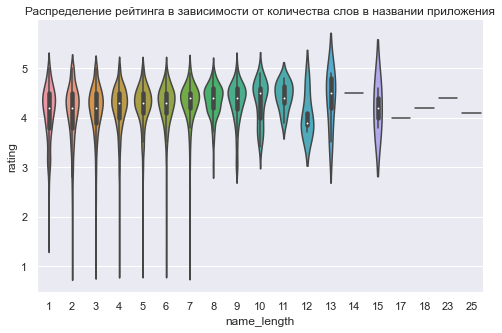

In [559]:
sns.violinplot(x=apps_df.name_length, y=apps_df.rating)
plt.title('Распределение рейтинга в зависимости от количества слов в названии приложения')
sns.despine()

#### Шаг 2
Взглянув на график распределений может заметить, что медиана растет по мере роста количества слов, токда как межквартильный размах уменьшается, то есть распределение становится более сконцентрированным.

Предположим, что длина названия позволяет пользователю более точно оценить пользу приложения до его установки и соотнести её со своими ожиданиями. То есть приложения с более развернутым названием меньше создает ложных ожиданий пользователя. Также эти приложения могут иметь более узкую целевую функцию, что, опять же, снижает разрыв между ожиданиями пользователей и ценностью, которую дает приложение.

Коротким названием будет считать название из 1 слова, а развернутыми - от 5 до 10 слов. Случаи, когда количество слов от 11  скорее можно считать исключением - таких наблюдений значительно меньше 1% всех наблюдений.

Сравним средние значения.

In [560]:
# Взглянем на количество наблюдений более 10
apps_df.query('name_length > 10').app.count()

31

In [561]:
# Количество приложений с названием из 5-10 слов
apps_df.query('name_length in [5,10]').app.count()

1069

In [562]:
# Количество приложений с названием из 1 слова
apps_df.query('name_length == 1').app.count()

584

In [563]:
# Среднее значение рейтинга приложений с названием из 5-10 слов
apps_df.query('name_length in [5,10]').rating.mean()

4.2289990645463

In [564]:
# Среднее значение рейтинга приложений с названием из 1 слова
apps_df.query('name_length == 1').rating.mean()

4.105993150684936

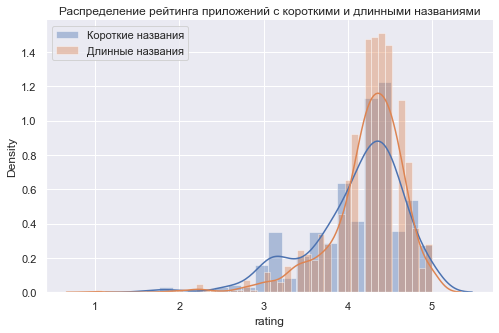

In [565]:
sns.distplot(apps_df.query('name_length == 1').rating, label = 'Короткие названия')
sns.distplot(apps_df.query('name_length in [5,10]').rating, label = 'Длинные названия')
plt.title('Распределение рейтинга приложений с короткими и длинными названиями')
plt.legend()
sns.despine()

In [566]:
# Рассчитаем t-критерий для 2 групп
stats.ttest_ind(apps_df.query('name_length == 1').rating, apps_df.query('name_length in  [5,10]').rating)

Ttest_indResult(statistic=-4.775983689188063, pvalue=1.94660420169157e-06)

#### Вывод
Полученное значение статистики и p-value (< 0.05) позволяет отвергнуть нулевую гипотезу о равенстве средних значений рейтинга для группы с коротким названием и группы с длинным названием.
Можно сделать вывод о том, что более развернутое название сокращает разрыв между ожиданиями пользователя и фактической ценностью приложения. Следовательно, важно при создании приложения давать ему название, развернуто и подробно описывающее его  сущность.

### 8. Модель, предсказывающая рейтинг приложения

#### Шаг 1
* Определим тип модели. Линейная регрессия вряд ли будет полезна, так как отсутствует очевидная линейная связь какого-либо признака и рейтинга приложения, к тому же значение рейтинга ограничено 5 звездами, это ограничение также отсекает модель линейной регрессии.



* Будем использовать дерево решений - довольно простой и эффективный инструмент построения моделей при помощи библиотеки sklearn. 

#### Шаг 2

* Добавим столбец с количеством дней с последнего обновления (за текущую дату возьмем дату самого позднего обновления в датафрейме)


* Применим к категориальным переменным метод pd.get_dummies() для преобразования их в признаки с бинарным значением для обработки моделью


* Определим x и y для нашей модели


* Применим модель к нашим данным


* Рассчитаем среднюю абсолютную ошибку (mean absolute error)



In [567]:
# Добавим колонку с количеством дней с последнего обновления приложения
apps_df['days_since_update'] = (apps_df.last_updated.max() - apps_df.last_updated).dt.days

In [568]:
df_dummies = pd.get_dummies(apps_df[['type','category']], drop_first = True)                        

In [569]:
df_model = pd.concat([apps_df[['app','reviews','days_since_update','price','installs','rating']],df_dummies], axis = 1)

In [570]:
# Определим X и y для нашей модели
X = df_model.drop(['rating','app'], axis = 'columns')
y = df_model.rating

In [571]:
# Импортируем необходимые пакеты из библиотеки sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [572]:
# Разделим данные на тестовые и валидационные. На валидационных мы проверим точность модели
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
# Определим модель
rating_model = DecisionTreeRegressor()
# Передадим ей тестовые данные
rating_model.fit(train_X, train_y)

# Сделаем предсказание на основе валидационных данных и оценим среднюю абсолютную ошибку
rating_predictions = rating_model.predict(val_X)
print('Абсолютная ошибка среднего для дерева решений: ',mean_absolute_error(val_y, rating_predictions))

Абсолютная ошибка среднего для дерева решений:  0.4567270058708415


#### Вывод
Полученная модель с ошибкой в 0,46 звезды предсказывает рейтинг приложения выглядит довольно убедительно, учитывая, что мы берем очень ограниченный перечень факторов. Однако лучший спосооб оценить точность модели - сравнить её результаты с результами другой модели.

Попробуем сравнить точность данной модели c точностью модели random forest.

In [573]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

rf_model.fit(train_X, train_y)

rf_val_mae = mean_absolute_error(val_y,rf_model.predict(val_X))

print("Абсолютная ошибка среднего для метода случайного леса: {}".format(rf_val_mae))

Абсолютная ошибка среднего для метода случайного леса: 0.34249263698630145


#### Вывод 2
Из 2 моделей, очевидно, более точно предсказывает рейтинг приложений модель random forest. При необходимости предсказать рейтинг приложения будем выбирать эту модель.